# Use Case 2: Semantic Search with Text Embeddings


### imports

In [14]:
import IPython
import sys

def clean_notebook():
    IPython.display.clear_output(wait=True)
    print("Notebook cleaned.")

# Run the installation commands
!pip install faiss-cpu
!pip install sentence-transformers
!pip install openai
!pip install gradio
!pip install tiktoken

# Clean up the notebook
clean_notebook()

Notebook cleaned.


In [4]:
import numpy as np
import pandas as pd

from sentence_transformers import SentenceTransformer

from sklearn.decomposition import PCA
from sklearn.metrics import DistanceMetric

import matplotlib.pyplot as plt
import matplotlib as mpl

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


### load data

In [5]:

# Corrected code to download the dataset
!wget -nc https://raw.githubusercontent.com/Tuchsanai/AIMaster-seagate-training-2024/main/Dataset/resumes/resumes_train.csv

!wget -nc https://raw.githubusercontent.com/Tuchsanai/AIMaster-seagate-training-2024/main/Dataset/resumes/resumes_test.csv

--2024-06-03 06:12:42--  https://raw.githubusercontent.com/Tuchsanai/AIMaster-seagate-training-2024/main/Dataset/resumes/resumes_train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 180695 (176K) [text/plain]
Saving to: ‘resumes_train.csv’

resumes_train.csv   100%[===================>] 176.46K  --.-KB/s    in 0.02s   

2024-06-03 06:12:42 (7.46 MB/s) - ‘resumes_train.csv’ saved [180695/180695]

--2024-06-03 06:12:42--  https://raw.githubusercontent.com/Tuchsanai/AIMaster-seagate-training-2024/main/Dataset/resumes/resumes_test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
H

In [7]:
df_resume = pd.read_csv('resumes_train.csv')
df_resume['role'][df_resume['role'].iloc[-1] == df_resume['role']] = "Other" # relabel random role as "other"
df_resume.head()

,resume,role
0,### John Doe\n\n---\n\n#### Summary\nDetail-or...,Data Scientist
1,Creating a resume for a Data Scientist based o...,Data Scientist
2,Creating a resume for a Data Scientist...\n\n-...,Data Scientist
3,Creating a resume for a Data Scientist based o...,Data Scientist
4,## John Doe\n\n---\n\n### Summary:\nData Scien...,Data Scientist


### generate embeddings

In [10]:
# import pre-trained model (full list: https://www.sbert.net/docs/pretrained_models.html)
model = SentenceTransformer("all-MiniLM-L6-v2",)


(100, 384)

In [24]:

# embed vectors
embedding_arr = model.encode(df_resume['resume'])
embedding_arr  = embedding_arr  / np.linalg.norm(embedding_arr )
embedding_arr.shape

(100, 384)

### Visualize Embeddings

#### PCA

In [25]:
# apply PCA to embeddings
pca = PCA(n_components=2).fit(embedding_arr)
print(pca.explained_variance_ratio_)

[0.20212618 0.12736847]


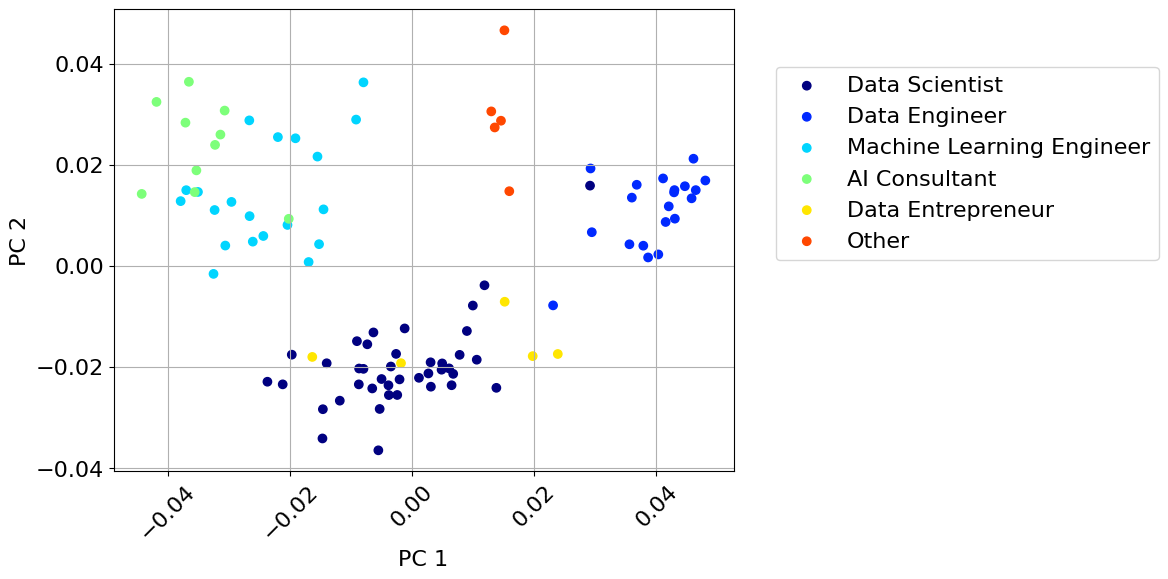

In [26]:
# plot data along PCA components
plt.figure(figsize=(8, 6))
plt.rcParams.update({'font.size': 16})
plt.grid()

c=0
cmap = mpl.colormaps['jet']
for role in df_resume['role'].unique():
    idx = np.where(df_resume['role']==role)
    plt.scatter(pca.transform(embedding_arr)[idx,0], pca.transform(embedding_arr)[idx,1], c=[cmap(c)]*len(idx[0]), label=role)
    c = c + 1/len(df_resume['role'].unique())

plt.legend(bbox_to_anchor=(1.05, 0.9))
plt.xticks(rotation = 45)
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.show()

### Semantic Search

In [27]:
import faiss

# Create and populate the Faiss index
d = embedding_arr.shape[1]  # Dimension of the embeddings

index = faiss.IndexFlatL2(d)
index.reset()

print("Number of vectors in the index: ", index.ntotal)
print("number of dimension = ", d)

Number of vectors in the index:  0
number of dimension =  384


In [28]:
# clear the index
index.reset()
# add the embedding vector to the index
index.add(embedding_arr)
print("Number of vectors in the index: ", index.ntotal)

Number of vectors in the index:  100


# Perform a Search with a Query

In [31]:
# Perform a search
def search_text(query, k=5):
    query_embedding = model.encode(query).reshape(1, -1)

    # norทalize the query embedding
    query_embedding = query_embedding / np.linalg.norm(query_embedding)
    distances, indices = index.search(query_embedding, k)

    return distances[0], indices[0]


In [32]:
query = "I need someone to build out my data infrastructure"
# query = "Co-founder for marketing analytics consultancy"
# query = "Project manager for AI feature development"

query = "Data Engineer with Apache Airflow experience"


distances, top_k_indices = search_text(query, k=5)

In [33]:
top_k_indices

array([48, 51, 47, 46, 41])

In [34]:
distances

array([0.8834994 , 0.88591325, 0.88817126, 0.89413583, 0.8944435 ],
      dtype=float32)

In [37]:
print("Query:", query)
print("====================================")

for i, idx in enumerate(top_k_indices):
    if idx < 0:
        continue
    print(f"Rank {i+1}:")
    print("class = ",df_resume.loc[idx, "role"])
    print("distance = ", distances[i])
    print(df_resume.loc[idx, "resume"])
    print("====================================")

Query: Data Engineer with Apache Airflow experience
Rank 1:
class =  Data Engineer
distance =  0.8834994
**John Doe**

---

**Summary:**
Highly skilled and experienced Data Engineer with a strong background in designing, implementing, and maintaining data pipelines. Proficient in data modeling, ETL processes, and data warehousing. Adept at working with large datasets and optimizing data workflows to improve efficiency.

---

**Professional Experience:**
- **Senior Data Engineer**  
  XYZ Tech, Anytown, USA  
  June 2018 - Present  
  - Designed and developed scalable data pipelines to handle terabytes of data daily.
  - Optimized ETL processes to improve data quality and processing time by 30%.
  - Collaborated with cross-functional teams to implement data architecture best practices.

- **Data Engineer**  
  ABC Solutions, Sometown, USA  
  January 2015 - May 2018  
  - Built and maintained data pipelines for real-time data processing.
  - Developed data models and implemented data go

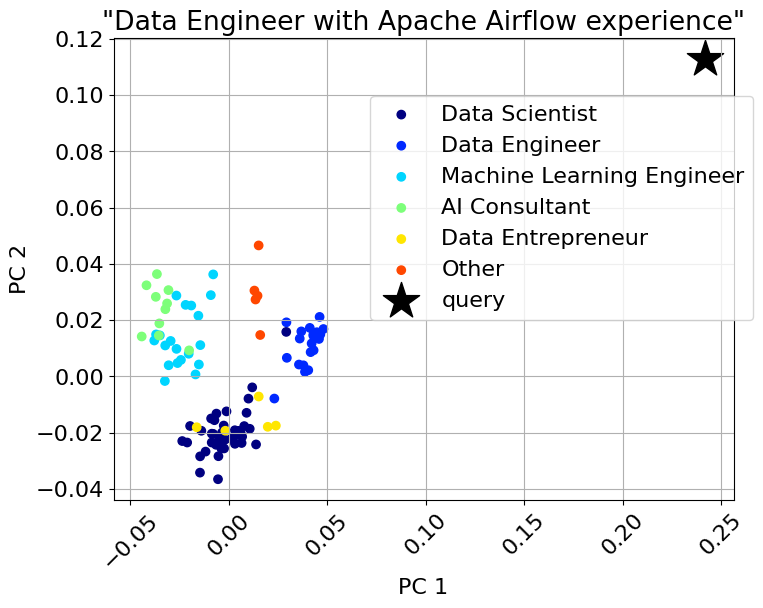

In [39]:

query_embedding = query_embedding / np.linalg.norm(query_embedding)# plot query along with resumes using PCA components
query_pca = pca.transform(query_embedding.reshape(1, -1))[0]

plt.figure(figsize=(8, 6))
plt.rcParams.update({'font.size': 16})
plt.grid()

c=0
cmap = mpl.colormaps['jet']
for role in df_resume['role'].unique():
    idx = np.where(df_resume['role']==role)
    plt.scatter(pca.transform(embedding_arr)[idx,0], pca.transform(embedding_arr)[idx,1], c=[cmap(c)]*len(idx[0]), label=role)
    c = c + 1/len(df_resume['role'].unique())

plt.scatter(query_pca[0], query_pca[1], c='k', marker='*', s=750, label='query')

plt.legend(bbox_to_anchor=(1.05, 0.9))
plt.xticks(rotation = 45)
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.title('"' + query + '"')
plt.show()